# Notebook for RETRIEVAL AUGMENTED GENERATION
This notebook is structured so that you can adjust the code to work with your scenario and tune it for different combinations of chunking parameters.
The values we'll be focusing on here are chunking size (in tokens) and overlap between consecutive chunks (also in tokens). As these values are used throughout the code, we recommend setting them in the beginning of the notebook, as part of step 0.

The notebook is structured so that you need to run it from Step 0, but if you already successfully completed any steps between 1 and 4 as part of previous runs, they can be skipped. This is convenient for time saving when you work with data volumes that require substantial amount of time for processing.

### Step 0. Initialization of the environment and workspace
If you have conda installed, you can create a new environment with the following command:
```bash
conda env create -f environment.yml
conda activate rag-e2e
```
This is the part where we read configuration and import modules that will be needed throughout the notebook. 

In [16]:
from dotenv import dotenv_values
import json
from pathlib import Path
import os
import pandas as pd
import re
import numpy as np
import time 
import PyPDF2
from azure.core.credentials import AzureKeyCredential

# specify the name of the .env file name 
env_name = "../../../.env" # change to your own .env file name
config = dotenv_values(env_name)

Set Up Azure AI Search Service

To set up Azure AI Search Service, you need to have an Azure subscription. If you don't have one, you can create a free account [here](https://azure.microsoft.com/en-us/free/). Once you have an Azure subscription, you can create an Azure AI Search Service by following the instructions [here](https://docs.microsoft.com/en-us/azure/search/search-create-service-portal) or [here](https://learn.microsoft.com/en-us/azure/search/search-create-service-portal).

You may choose a free tier for the Azure AI Search Service, which allows you to have 3 indexes and 50 MB of storage. The free tier is sufficient for this notebook.

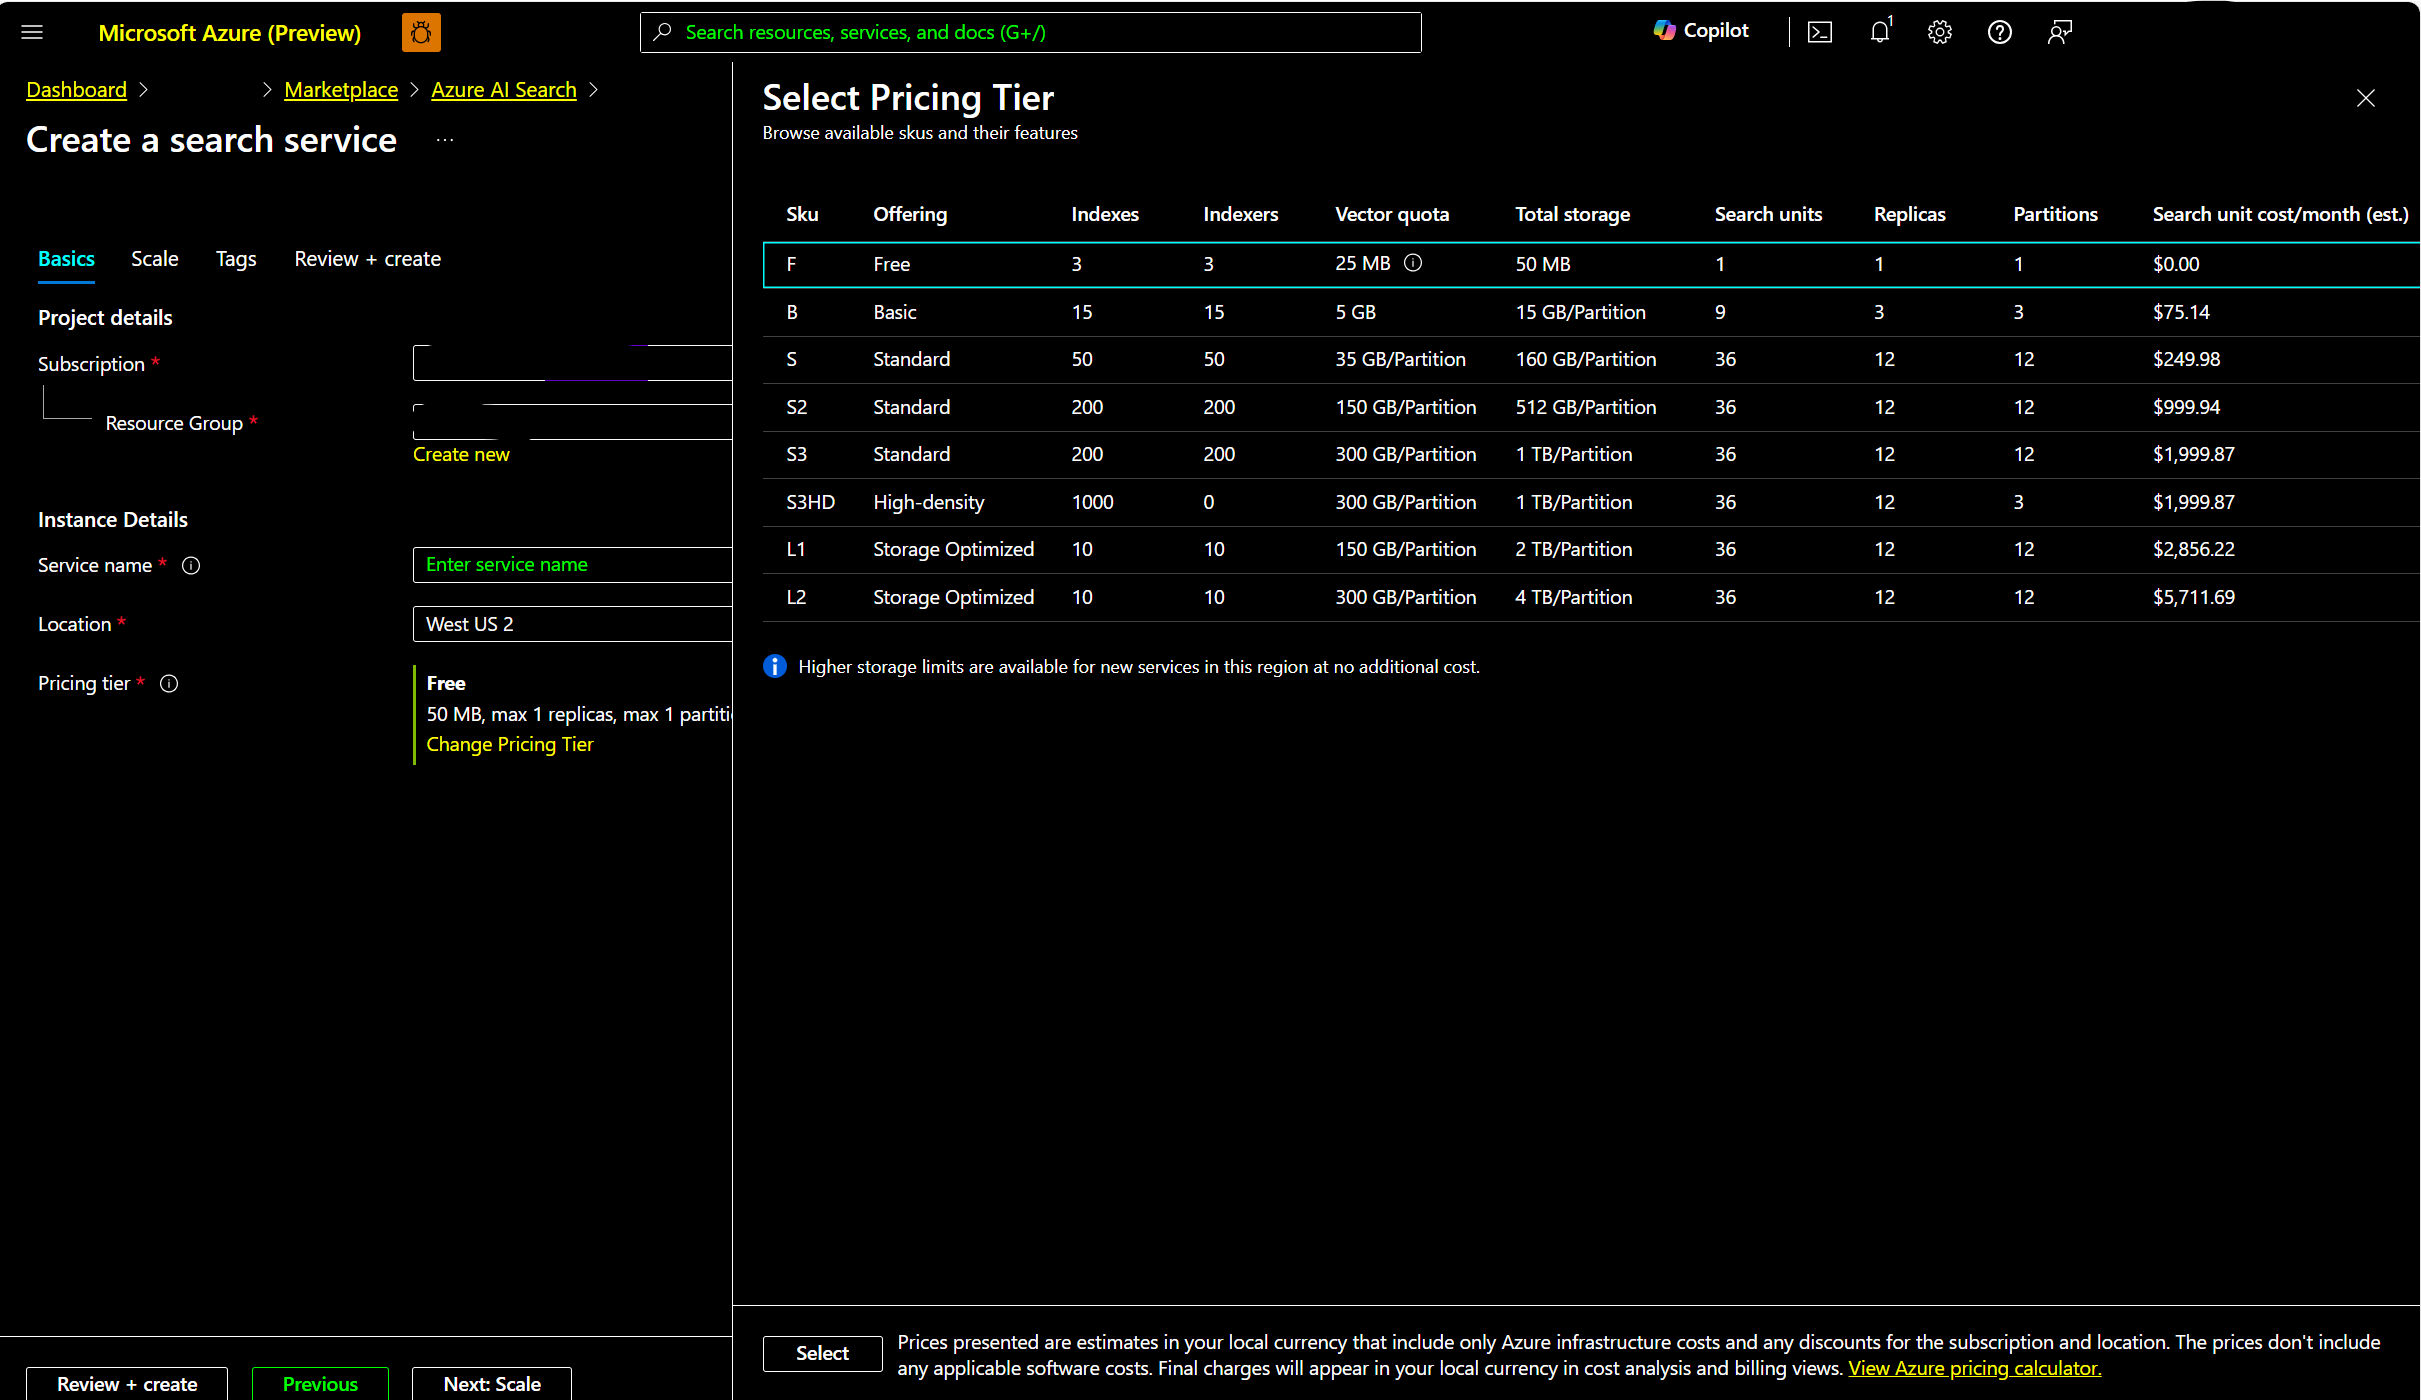

Next, we set up configuration for the experiment via 3 variables. For considerations on picking most reasonable values for your scenarios, check aka.ms/chunk_size.

In [2]:
dataset_name = "mft"
chunk_size=2048
chunk_overlap=10
top_n=2

Below we're printing an identifier name for the experiment derived from the parameters configured above. It will be used in the rest of the notebook as part of filenames, configuration of generated indices, etc. It allows to immediately say which parameters were used in the run (e.g. here it's "Microsoft financial transcripts" dataset, with chunksize of 2048 tokens and overlap of 10 tokens between them). Preserving it for tracking purposes and benchmarking is useful

In [3]:
experiment_name = f"{dataset_name}_top{top_n}n_s{chunk_size}t_o{chunk_overlap}t"
print(experiment_name)

mft_top2n_s2048t_o10t


### Step1: Download and transform data

The purpose of this step we have already collected, curated and transformed data to pdf format, in the DATA subdirectory. The data is in the form of PDF files, and we will convert it to a JSON format that can be used by the RAG model.
Original sources are from here, for example: Msft Earning Call Transcripts for 2023-Q4
https://www.fool.com/earnings/call-transcripts/2023/07/25/microsoft-msft-q4-2023-earnings-call-transcript/


Convert the PDF files into text with positional metadata and dump intermediate results as json files locally (this way you don't have to run the notebook from scratch every time, you can start from the step where you left off). 

This code sample shows pypdf2 library usage to extract text from PDF files. It is a simple and easy-to-use library for reading PDF files. It is not the most powerful library, but it is sufficient for this task. For production level use, you may use Azure Document Intelligence or other libraries.

To learn more, please visit the documentation - Quickstart: Form Recognizer Python client library SDKs
https://docs.microsoft.com/en-us/azure/applied-ai-services/form-recognizer/quickstarts/try-v3-python-sdk

In [4]:
# Extract line number and page number

def create_tuples_with_position_metadata(pdf_reader, file_name):
    """
    Input: PDF reader object from PyPDF2
    Output: Create list of tuples of the form (line, position)
    This will keep reference of the line number and page number of each line in the document.
    """
    line_page_tuples = []
    
    for page_num in range(len(pdf_reader.pages)):
        page = pdf_reader.pages[page_num]
        text = page.extract_text()
        lines = text.split('\n') if text else []
        
        for line_num, line in enumerate(lines):
            line_page_tuples.append((line, f"{file_name}, P.{page_num + 1}, line {line_num + 1}"))
    
    return line_page_tuples

In [5]:
import io
def analyze_pdf(doc_path):
    """
    Analyze PDF and return the PDF reader object.
    """
    with open(doc_path, "rb") as f:
        pdf_bytes = f.read()
    pdf_reader = PyPDF2.PdfReader(io.BytesIO(pdf_bytes))
    return pdf_reader

doc_dir = Path("DATA/")
pdf_files = [filename for filename in os.listdir(doc_dir) if filename.endswith('.pdf')]


for file_name in pdf_files:
    file_path_in = os.path.join(doc_dir, file_name)
    
    # analyze the pdf using PyPDF2
    pdf_reader = analyze_pdf(file_path_in)
    
    line_position_tuples = create_tuples_with_position_metadata(pdf_reader, file_name)

    # Saving results to json files
    output_dir = Path(f"AnalyzedPDF/{experiment_name}")
    if not output_dir.exists():
        output_dir.mkdir(parents=True, exist_ok=True)

    print('Writing the results of: \n' + file_name)
    file_path_out = output_dir / f"{os.path.splitext(file_name)[0]}.json"
    
    if not file_path_out.exists():
        # Convert and write JSON object to file
        with open(file_path_out, "w") as outfile:
            json.dump(line_position_tuples, outfile)
    else:
        print(f'{file_path_out} already exists, skipping...')

Writing the results of: 
MSFTTranscriptFY23Q1.pdf
Writing the results of: 
MSFTTranscriptFY23Q2.pdf
Writing the results of: 
MSFTTranscriptFY23Q3.pdf
Writing the results of: 
MSFTTranscriptFY23Q4.pdf


### Step 2. Preprocessing: Chunking, Embedding, and Filtering

In this stage we take text segments with positional references that was generated in stage 1 and dumped as json, and convert this input according to the specificaiton for chunking set in the beginning of this notebook. We also have custom code for adding filtering at later stage. If filtering is not needed, this code can be removed or simplified (instead of actual values for filtering, dummy value can be added)

In [6]:

# Extract stock symbol, year, and quarter from filename
def extract_info_from_filename(filename):
    '''
    Input: filename ("MSFTTranscriptFY23Q4")
    Output: Extract stock symbol, year and quarter from filename
    '''
    pattern = r'([A-Z]+)TranscriptFY(\d{2})Q(\d)'
    match = re.search(pattern, filename)
    
    if match:
        symbol = match.group(1)
        fiscal_year = match.group(2)
        fiscal_quarter = match.group(3)
        return symbol, fiscal_year, fiscal_quarter
    else:
        return None
    
# Extract line number and page number
def chunk_in_tokens(lines_with_position_metadata, chunk_length, chunk_overlap_length):
    return chunk_in_chars(lines_with_position_metadata, chunk_length*4, chunk_overlap_length*4)

def chunk_in_chars(lines_with_position_metadata, chunk_length, chunk_overlap_length):
    chunks = []
    current_chunk = ""
    current_position = 0
    for line, position in lines_with_position_metadata:
        while len(line) > chunk_length:
            chunks.append((line[:chunk_length], position))
            line = line[chunk_length - chunk_overlap_length:]
            current_position += chunk_length - chunk_overlap_length
        current_chunk = current_chunk + line + " "
        if len(current_chunk) >= chunk_length:
            chunks.append((current_chunk[:chunk_length], position))
            current_chunk = current_chunk[chunk_length - chunk_overlap_length:]
            current_position =  chunk_length - chunk_overlap_length
        else:
            current_chunk += " "
    if current_chunk:
        chunks.append((current_chunk, position))
    return chunks


In [7]:
doc_dir = Path(f"AnalyzedPDF/{experiment_name}") 
files = [filename for filename in os.listdir(doc_dir) if filename.endswith('.json')]

dfs = []

for file_name in files:
    
    file_path = os.path.join(doc_dir, f"{os.path.splitext(file_name)[0]}.json")
    # Opening JSON file
    f = open(file_path)
    
    # returns JSON object as 
    # a dictionary
    data = json.load(f)

    # get the chunks in a tuple of the form (chunk, page_number, line_number)
    chunks = chunk_in_tokens(data, chunk_size, chunk_overlap)   

    # Write results to dataframe 
    df_chunks = pd.DataFrame(chunks, columns = ['Chunk', 'Position'])  

    # todo: one field called 'Filter' instead of individual fields
    df_chunks["Ticker"], df_chunks["Year"], df_chunks["Quarter"]  = "NULL", "NULL", "NULL"

    values = extract_info_from_filename(file_name) # symbol, fiscal_year, fiscal_quarter
   
    if values:
        symbol, fiscal_year, fiscal_quarter = values
        df_chunks["Ticker"], df_chunks["Year"], df_chunks["Quarter"]  = symbol, fiscal_year, fiscal_quarter
        
    # Reorder dataframe column name
    new_column_order = ['Ticker', 'Year', 'Quarter', 'Chunk', 'Position']
    df_chunks = df_chunks[new_column_order]
        
    # Add all datframe to list
    dfs.append(df_chunks)
 

    print('writing the results of: \n' + file_name)  
    file_path=f"AnalyzedPDF/{experiment_name}/Chunks_{experiment_name}_{file_name[0:-4]}.csv"
    if not os.path.exists(file_path):
        df_chunks.to_csv(file_path, index=False)
    else:
        print(f'{file_path} already exists, skipping...')
        
## Combine all the files
df = pd.concat(dfs, ignore_index=True)
df = df.reset_index(drop=True)
df.insert(0, 'Id', [i for i in range(1, df.shape[0]+1)]) # Add 'Id' column

## Save to csv
df.to_csv(f"AnalyzedPDF/{experiment_name}/Chunks_{experiment_name}.csv", index=False)

df.head()


writing the results of: 
MSFTTranscriptFY23Q1.json
writing the results of: 
MSFTTranscriptFY23Q2.json
writing the results of: 
MSFTTranscriptFY23Q3.json
writing the results of: 
MSFTTranscriptFY23Q4.json


,Id,Ticker,Year,Quarter,Chunk,Position
0,1,MSFT,23,1,Microsoft FY23 First Quarter Earnings Conferen...,"MSFTTranscriptFY23Q1.pdf, P.8, line 20"
1,2,MSFT,23,1,aining cost efficiencies. Darden is using o...,"MSFTTranscriptFY23Q1.pdf, P.17, line 9"
2,3,MSFT,23,1,reach players wherever and whenever they wan...,"MSFTTranscriptFY23Q1.pdf, P.24, line 16"
3,4,MSFT,23,1,e grew 5 percent and 10 percent in constant c...,"MSFTTranscriptFY23Q1.pdf, P.32, line 2"
4,5,MSFT,23,1,"benefit from Microsoft 365 suite momentum, t...","MSFTTranscriptFY23Q1.pdf, P.38, line 17"


#### Load the chunks and create embedding
In this section, we will load the data into a pandas dataframe, use select columns, and create vector embedding using azure open ai. 

In [11]:
import openai
from openai import AzureOpenAI
from tenacity import retry, wait_random_exponential, stop_after_attempt  

openai.api_type = config["OPENAI_API_TYPE"] 
openai.api_key = config["OPENAI_API_KEY"]
openai.api_base = config["OPENAI_API_BASE"] 
openai.api_version = config["OPENAI_API_VERSION"] 

"""
def createEmbeddings(text):
    response = openai.Embedding.create(input=text , engine=config["OPENAI_DEPLOYMENT_EMBEDDING"])
    embeddings = response['data'][0]['embedding']
    return embeddings
"""
    
client = AzureOpenAI(
  api_key =  config["OPENAI_API_KEY"],  
  api_version = "2023-05-15",
  azure_endpoint = config["OPENAI_API_BASE"]
)
 
model: str = "text-embedding-ada-002" 
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
# Function to generate embeddings for title and content fields, also used for query embeddings
def createEmbeddings(text, model=model):
    return client.embeddings.create(input = [text], model=model).data[0].embedding


df = pd.read_csv(f"AnalyzedPDF/{experiment_name}/Chunks_{experiment_name}.csv")


# Create a new column called 'embedding' in the DataFrame
df['Embedding'] = np.empty((len(df),), dtype=object)

# Iterate over each row in the DataFrame and assign the concatenation and embeddings
for index, row in df.iterrows():
    text = row['Chunk']
    
    # Concatenate the desired columns
    concat_text = f"{text}"
    
    # Create embeddings using the provided function
    embeddings = createEmbeddings(concat_text)
    #print(embeddings)
    
    # Assign the embeddings to the 'embedding' column
    df.at[index, 'Embedding'] = embeddings
    time.sleep(0.1)


In [12]:
df.head(10)

,Id,Ticker,Year,Quarter,Chunk,Position,Embedding
0,1,MSFT,23,1,Microsoft FY23 First Quarter Earnings Conferen...,"MSFTTranscriptFY23Q1.pdf, P.8, line 20","[-0.019452229142189026, -0.019383830949664116,..."
1,2,MSFT,23,1,aining cost efficiencies. Darden is using o...,"MSFTTranscriptFY23Q1.pdf, P.17, line 9","[-0.005985373631119728, -0.02419649250805378, ..."
2,3,MSFT,23,1,reach players wherever and whenever they wan...,"MSFTTranscriptFY23Q1.pdf, P.24, line 16","[0.008331112563610077, -0.013644391670823097, ..."
3,4,MSFT,23,1,e grew 5 percent and 10 percent in constant c...,"MSFTTranscriptFY23Q1.pdf, P.32, line 2","[0.006754951551556587, -0.010016310960054398, ..."
4,5,MSFT,23,1,"benefit from Microsoft 365 suite momentum, t...","MSFTTranscriptFY23Q1.pdf, P.38, line 17","[0.00039735797327011824, -0.024531906470656395..."
5,6,MSFT,23,1,"ility to this number. And here, I think you ...","MSFTTranscriptFY23Q1.pdf, P.44, line 12","[0.0006808381876908243, -0.027212869375944138,..."
6,7,MSFT,23,1,"hanks, Mark. Jess i, next question, please. ...","MSFTTranscriptFY23Q1.pdf, P.50, line 7","[-0.004816135857254267, -0.027348527684807777,..."
7,8,MSFT,23,1,"t LinkedIn B2B advertising, where we clearly...","MSFTTranscriptFY23Q1.pdf, P.51, line 14","[-0.01922553777694702, -0.014509577304124832, ..."
8,9,MSFT,23,2,Microsoft FY23 Second Quarter Earnings Confere...,"MSFTTranscriptFY23Q2.pdf, P.5, line 33","[-0.0217574629932642, -0.019318774342536926, -..."
9,10,MSFT,23,2,ing new AI -powered features to turn natural l...,"MSFTTranscriptFY23Q2.pdf, P.11, line 1","[-0.010827068239450455, -0.00806916318833828, ..."


Use the following code to save the embeddings and processed data for future use or skip the previous part of the code and load the processed data to save into the db. 

In [13]:
# save CSV for future use. 
df.to_csv(f"AnalyzedPDF/{experiment_name}/ChunksEmbedding_{experiment_name}.csv", index=False)

### Store chunks into Vector Database using Azure Cognitive Search (ACS)

In [15]:
from azure.core.credentials import AzureKeyCredential  
from azure.search.documents import SearchClient  
from azure.search.documents.indexes import SearchIndexClient  
from azure.search.documents.models import Vector  
from azure.search.documents.indexes.models import (  
    SearchIndex,  
    SearchField,  
    SearchFieldDataType,  
    SimpleField,  
    SearchableField, 
    SemanticConfiguration,  
    PrioritizedFields,  
    SemanticField,  
    SemanticSettings,  
    VectorSearch,  
    HnswVectorSearchAlgorithmConfiguration
)
from ast import literal_eval

Load environment variables and keys:

In [17]:
## Cog Search
index_name = config["COGSEARCH_INDEX_NAME"]
key = config["COGSEARCH_API_KEY"]
service_endpoint = config["COGSEARCH_ADDRESS"] #+ ".search.windows.net"

credential = AzureKeyCredential(key)

Load data prepared at previous steps:

In [18]:
df_chunks_embedding = pd.read_csv(f"AnalyzedPDF/{experiment_name}/ChunksEmbedding_{experiment_name}.csv")
df_chunks_embedding.head(3)

,Id,Ticker,Year,Quarter,Chunk,Position,Embedding
0,1,MSFT,23,1,Microsoft FY23 First Quarter Earnings Conferen...,"MSFTTranscriptFY23Q1.pdf, P.8, line 20","[-0.019452229142189026, -0.019383830949664116,..."
1,2,MSFT,23,1,aining cost efficiencies. Darden is using o...,"MSFTTranscriptFY23Q1.pdf, P.17, line 9","[-0.005985373631119728, -0.02419649250805378, ..."
2,3,MSFT,23,1,reach players wherever and whenever they wan...,"MSFTTranscriptFY23Q1.pdf, P.24, line 16","[0.008331112563610077, -0.013644391670823097, ..."


Created index configurations:

In [19]:
index_name=f"index__{experiment_name}"
# Create a search index
#experiment_name = "scifacts_s128t_o10t"
vs_config_name=f"{experiment_name}-vector-config"


index_client = SearchIndexClient(
    endpoint=service_endpoint, credential=credential)
fields = [
    SimpleField(name="Id", type=SearchFieldDataType.String, key=True, sortable=True, filterable=True, facetable=True),
    SearchableField(name="Filter", type=SearchFieldDataType.String, filterable=True),
    SearchableField(name="Chunk", type=SearchFieldDataType.String, searchable=True),
    SearchableField(name="Position", type=SearchFieldDataType.String, filterable=True),
    SearchField(name="Embedding", type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                searchable=True, vector_search_dimensions=1536, vector_search_configuration=vs_config_name),
]


vector_search = VectorSearch(
    algorithm_configurations=[
        HnswVectorSearchAlgorithmConfiguration(
            name=vs_config_name,
           # name="my-vector-config",
            kind="hnsw",
            parameters={
                "m": 4,
                "efConstruction": 400,
                "efSearch": 500,
                "metric": "cosine" # cosine, euclidean, and dotProduct are valid metrics
            }
        )
    ]
)

ss_config_name=f"{experiment_name}-semantic-config"
semantic_config = SemanticConfiguration(
    name=ss_config_name,
    #name="my-semantic-config",
    prioritized_fields=PrioritizedFields(
        title_field=SemanticField(field_name="Filter"),
        prioritized_content_fields=[SemanticField(field_name="Chunk")]
    )
)

# Create the semantic settings with the configuration
semantic_settings = SemanticSettings(configurations=[semantic_config])

# Create the search index with the semantic settings
index = SearchIndex(name=index_name, fields=fields,
                    vector_search=vector_search, semantic_settings=semantic_settings)
result = index_client.create_or_update_index(index)
print(f' {result.name} created')

 index__mft_top2n_s2048t_o10t created


Finally, upload prepared data to index:

In [48]:

## Upload data to Index
def batch_append_payload(df, search_client):
    """append payload for batch insertion (note: max 1000 rows per insertion) of embeddings to Cognitive Search"""
    value_list = []
    for index, row in df.iterrows():
        value_list.append(
            {
                "Id": str(index),
                "Filter": str(row["Ticker"])+"FY"+str(row["Year"])+"Q"+str(row["Quarter"]),
                "Chunk": row["Chunk"],
                "Position": str(row["Position"]),
                "Embedding": literal_eval(row['Embedding']),
            }
        )
        
        if len(value_list) >= 1000:
            result = search_client.upload_documents(value_list)
            print(f"Uploaded {len(value_list)} payload")
            value_list = []
    result = search_client.upload_documents(value_list)
    print(f"Uploaded {len(value_list)} payload")

    return value_list

search_client = SearchClient(endpoint=service_endpoint, index_name=index_name, credential=credential)
payload = batch_append_payload(df_chunks_embedding, search_client)
 


Uploaded 30 payload


### Step 3. Types of Retrievals

#### Search Type 1: Pure Vector Search

Pure vector search involves searching for the most similar vectors to the query vector. This is the most basic form of search and is used to find the most similar documents to the query, based on the vector embeddings similarity search. Note that search type

In [133]:
query = "How many monthly active users does Power BI have in FY23Q1?"
    
search_client = SearchClient(service_endpoint, index_name, credential=credential)  
vector = Vector(value=createEmbeddings(query), k=5, fields="Embedding")  

results = search_client.search(  
    search_text=None,  
    vectors=[vector]
)  

context=""
for result in results: 
  print(result['Chunk'])
  context+=result["Chunk"]
print(context)

Microsoft FY23 Third Quarter Earnings Conference  Call   Brett Iversen, Satya Nadella, Amy Hood    Tuesday, April 25, 2023       BRETT IVERS EN:       Good afternoon and thank you for joining us today. On the call with me are   Satya Nadella, chairman and chief executive officer, Amy Hood, chief   financial officer, Alice Jolla , chief accounting officer,  and Keith Dolliver,   deputy general counsel.       On the Microsoft Investor Relations website, you can find our earnings   press release and financial summary slide deck, which is intended to   supplement our prepared remarks during today’s call and provides the   reconciliation of differences between GAAP and non -GAAP financial   measures.  Additionally, new this quarter, more detailed outlook slides will   be available on the Microsoft Investor Relations  website when we provide   outlook commentary on today’s call .      On this call we will discuss certain non -GAAP items. The non -GAAP financial   measures provided should not

### Search Type 2: Pure Filter Search

In [58]:
# Find all chunks from FY23 Q2
results = search_client.search(  
    search_text=None,  
    filter="(Filter eq 'MSFTFY23Q2') ",
)  

for result in results:
    print(result)

{'Position': 'MSFTTranscriptFY23Q2.pdf, P.5, line 33', 'Chunk': "Microsoft FY23 Second Quarter Earnings Conference Call     Brett Iversen, Satya Nadella, Amy Hood     Tuesday, January 24, 2023          BRETT IVERSEN:       Good afternoon and thank you for joining us today. On the call with me are   Satya Nadella, chairman and chief executive officer, Amy Hood, chief   financial officer, Alice Jolla, chief accounting officer, and Keith Dolliver,   deputy general counsel.       On the Microsoft Investor Relations website, you can find our earnings   press release and financial summary slide deck, which is intended to   supplement our prepared remarks during today’s call and provides the   reconciliation of differences between GAAP and non-GAAP financial   measures.       On this call we will discuss certain non -GAAP items. The non-GAAP financial   measures provided should not be considered as a  substitute for or superior   to the measures of financial performance prepared in accordance

### Search Type 3: Hybrid Search

In [137]:
# Extract quarter of earnings pubication
def extract_time_context(line: str) -> str:
    match = re.search(r"\bFY\d{2}Q\d\b", line)
    if match:
        return match.group()
    else:
        return ""

FY23Q1
FY23Q2


In [158]:
# Example usage
sentence1 = "How many monthly active users does Power BI have in FY23Q1?"
sentence2 = "What are some examples of companies using Azure OpenAI Service in FY23Q2?"
print(extract_time_context(sentence1))  # Output: FY23Q1
print(extract_time_context(sentence2))  # Output: FY23Q2

FY23Q1
FY23Q2


In [186]:
query = "How many monthly active users does Power BI have in FY23Q1?"
filter_value='MSFT'+extract_time_context(query)
    
search_client = SearchClient(service_endpoint, index_name, credential=credential)  
vector = Vector(value=createEmbeddings(query), k=5, fields="Embedding")   # k = number of similar chunks

results = search_client.search(  
    search_text=None,  
    vectors=[vector],
    filter = f"(Filter eq '{filter_value}')"
)  

output=[] 
for result in results: 
  print(result)

{'Position': 'MSFTTranscriptFY23Q1.pdf, P.8, line 20', 'Chunk': "Microsoft FY23 First Quarter Earnings Conference Call    Brett Iversen, Satya Nadella, Amy Hood    Tuesday, October 25, 2022       BRETT IVERSEN:    Good afternoon and thank you for joining us today. On the call with me are   Satya Nadella, chairman and chief executive officer, Amy Hood, chief   financial officer, Alice Jolla, chief accounting officer, and Keith Dolliver,   deputy general counsel.       On the Microsoft Investor Relations website, you can find our earnings   press release and financial summary slide deck, which is intended to   supplement our prepared remarks during today’s call and provides the   reconciliation of differences between GAAP and non-GAAP financial   measures.       On this call we will discuss certain non -GAAP items. The non -GAAP financial   measures provided should not be considered as a  substitute for or superior   to the measures of financial performance prepared in accordance with   

In [62]:
result.keys()

dict_keys(['Position', 'Chunk', 'Id', 'Embedding', 'Filter', '@search.score', '@search.reranker_score', '@search.highlights', '@search.captions'])

### Step 5. Evaluation of ALL Retrievals

In [190]:
import pandas as pd

def fetch_relevant_chunks_as_df(query, n=1):
    filter_value = 'MSFT' + extract_time_context(query)
    search_client = SearchClient(service_endpoint, index_name, credential=credential)
    vector = Vector(value=createEmbeddings(query), k=n, fields="Embedding")

    results = search_client.search(
        search_text=None,
        vectors=[vector],
        filter=f"(Filter eq '{filter_value}')"
    )

    rows = [
        {
            'position': result.get('Position'),
            'chunk': result.get('Chunk'),
            'filter': result.get('Filter'),
            'score': result.get('@search.score'), # The relevance score of the result
            'question': query
        }
        for result in results
    ]

    if not rows:
        print(f"No results found for query: {query}")

    return pd.DataFrame(rows)

def fetch_relevant_chunks_for_multiple_questions(queries, n=1):
    return pd.concat(
        [fetch_relevant_chunks_as_df(query, n) for query in queries],
        ignore_index=True
    )

# Example usage
queries = [
    "How many monthly active users does Power BI have in FY23Q1?", 
    "Which companies run SAP on Azure in FY23Q1?"
]
result_df = fetch_relevant_chunks_for_multiple_questions(queries, 5)
result_df



,position,chunk,filter,score,question
0,"MSFTTranscriptFY23Q1.pdf, P.8, line 20",Microsoft FY23 First Quarter Earnings Conferen...,MSFTFY23Q1,0.826902,How many monthly active users does Power BI ha...
1,"MSFTTranscriptFY23Q1.pdf, P.8, line 20",Microsoft FY23 First Quarter Earnings Conferen...,MSFTFY23Q1,0.838771,Which companies run SAP on Azure in FY23Q1?


In [25]:
benchmark_file="evalset.csv"

In [49]:
doc_dir = Path("DATA/") 
file_path = os.path.join(doc_dir, benchmark_file)
benchmark=pd.read_csv(file_path) 
benchmark

,question,answer
0,What is the quarterly revenue of Microsoft Clo...,"$25 billion in quarterly revenue, up 24 percen..."
1,How many Azure Arc customers does Microsoft cu...,"More than 8,500 Arc customers, more than doubl..."
2,Which companies run SAP on Azure in FY23Q1?,"Companies like Chobani, Munich RE, Sodexo, Vol..."
3,What is the annual recurring revenue of GitHub...,GitHub is now at $1 billion in annual recurrin...
4,How many monthly active users does Power BI ha...,Power BI is the market leader in business inte...
5,What is the quarterly revenue of Microsoft Clo...,"$27 billion in quarterly revenue, up 22 percen..."
6,How many Azure Arc customers does Microsoft cu...,"More than 12,000 Arc customers, double the num..."
7,What are some examples of companies using Azur...,"Over 200 customers, including KPMG and Al Jaze..."
8,How many developers are using GitHub Copilot a...,More than one million people have used GitHub ...
9,What is the growth rate of Azure Machine Learn...,Azure ML revenue alone has increased more than...


In [193]:
questions_list = benchmark['question'].tolist()
top_n=10
relevant_chunks=fetch_relevant_chunks_for_multiple_questions(questions_list, top_n)
merged_df = pd.merge(relevant_chunks, benchmark, on='question')
merged_df

,position,chunk,filter,score,question,answer
0,"MSFTTranscriptFY23Q1.pdf, P.38, line 17","benefit from Microsoft 365 suite momentum, t...",MSFTFY23Q1,0.873958,What is the quarterly revenue of Microsoft Clo...,"$25 billion in quarterly revenue, up 24 percen..."
1,"MSFTTranscriptFY23Q1.pdf, P.8, line 20",Microsoft FY23 First Quarter Earnings Conferen...,MSFTFY23Q1,0.868515,What is the quarterly revenue of Microsoft Clo...,"$25 billion in quarterly revenue, up 24 percen..."
2,"MSFTTranscriptFY23Q1.pdf, P.8, line 20",Microsoft FY23 First Quarter Earnings Conferen...,MSFTFY23Q1,0.844970,How many Azure Arc customers does Microsoft cu...,"More than 8,500 Arc customers, more than doubl..."
3,"MSFTTranscriptFY23Q1.pdf, P.38, line 17","benefit from Microsoft 365 suite momentum, t...",MSFTFY23Q1,0.840632,How many Azure Arc customers does Microsoft cu...,"More than 8,500 Arc customers, more than doubl..."
4,"MSFTTranscriptFY23Q1.pdf, P.8, line 20",Microsoft FY23 First Quarter Earnings Conferen...,MSFTFY23Q1,0.838771,Which companies run SAP on Azure in FY23Q1?,"Companies like Chobani, Munich RE, Sodexo, Vol..."
5,"MSFTTranscriptFY23Q1.pdf, P.38, line 17","benefit from Microsoft 365 suite momentum, t...",MSFTFY23Q1,0.836598,What is the annual recurring revenue of GitHub...,GitHub is now at $1 billion in annual recurrin...
6,"MSFTTranscriptFY23Q1.pdf, P.8, line 20",Microsoft FY23 First Quarter Earnings Conferen...,MSFTFY23Q1,0.826902,How many monthly active users does Power BI ha...,Power BI is the market leader in business inte...
7,"MSFTTranscriptFY23Q1.pdf, P.38, line 17","benefit from Microsoft 365 suite momentum, t...",MSFTFY23Q1,0.823700,How many monthly active users does Power BI ha...,Power BI is the market leader in business inte...
8,"MSFTTranscriptFY23Q2.pdf, P.19, line 32","ctations. Overall, server products and c...",MSFTFY23Q2,0.881056,What is the quarterly revenue of Microsoft Clo...,"$27 billion in quarterly revenue, up 22 percen..."
9,"MSFTTranscriptFY23Q2.pdf, P.5, line 33",Microsoft FY23 Second Quarter Earnings Confere...,MSFTFY23Q2,0.872720,What is the quarterly revenue of Microsoft Clo...,"$27 billion in quarterly revenue, up 22 percen..."


In [194]:
relevant_chunks

,position,chunk,filter,score,question
0,"MSFTTranscriptFY23Q1.pdf, P.38, line 17","benefit from Microsoft 365 suite momentum, t...",MSFTFY23Q1,0.873958,What is the quarterly revenue of Microsoft Clo...
1,"MSFTTranscriptFY23Q1.pdf, P.8, line 20",Microsoft FY23 First Quarter Earnings Conferen...,MSFTFY23Q1,0.868515,What is the quarterly revenue of Microsoft Clo...
2,"MSFTTranscriptFY23Q1.pdf, P.8, line 20",Microsoft FY23 First Quarter Earnings Conferen...,MSFTFY23Q1,0.844970,How many Azure Arc customers does Microsoft cu...
3,"MSFTTranscriptFY23Q1.pdf, P.38, line 17","benefit from Microsoft 365 suite momentum, t...",MSFTFY23Q1,0.840632,How many Azure Arc customers does Microsoft cu...
4,"MSFTTranscriptFY23Q1.pdf, P.8, line 20",Microsoft FY23 First Quarter Earnings Conferen...,MSFTFY23Q1,0.838771,Which companies run SAP on Azure in FY23Q1?
5,"MSFTTranscriptFY23Q1.pdf, P.38, line 17","benefit from Microsoft 365 suite momentum, t...",MSFTFY23Q1,0.836598,What is the annual recurring revenue of GitHub...
6,"MSFTTranscriptFY23Q1.pdf, P.8, line 20",Microsoft FY23 First Quarter Earnings Conferen...,MSFTFY23Q1,0.826902,How many monthly active users does Power BI ha...
7,"MSFTTranscriptFY23Q1.pdf, P.38, line 17","benefit from Microsoft 365 suite momentum, t...",MSFTFY23Q1,0.823700,How many monthly active users does Power BI ha...
8,"MSFTTranscriptFY23Q2.pdf, P.19, line 32","ctations. Overall, server products and c...",MSFTFY23Q2,0.881056,What is the quarterly revenue of Microsoft Clo...
9,"MSFTTranscriptFY23Q2.pdf, P.5, line 33",Microsoft FY23 Second Quarter Earnings Confere...,MSFTFY23Q2,0.872720,What is the quarterly revenue of Microsoft Clo...


In [195]:
questions_list

['What is the quarterly revenue of Microsoft Cloud in FY23Q1?',
 'How many Azure Arc customers does Microsoft currently have in FY23Q1?',
 'Which companies run SAP on Azure in FY23Q1?',
 'What is the annual recurring revenue of GitHub in FY23Q1?',
 'How many monthly active users does Power BI have in FY23Q1?',
 'What is the quarterly revenue of Microsoft Cloud in FY23Q2?',
 'How many Azure Arc customers does Microsoft currently have in FY23Q2?',
 'What are some examples of companies using Azure OpenAI Service in FY23Q2?',
 'How many developers are using GitHub Copilot as of FY23Q2?',
 'What is the growth rate of Azure Machine Learning revenue in FY23Q1?']

In [196]:
template = """
        You are given a question and a relevant piece of context. Use only the context to answer the question.
            If answer is not available in the text, say it is not available.
               
        An example:
        question: "How many developers are using GitHub Copilot as of FY23Q2?": 
        context: <relevant context>
        answer: "More than one million people have used GitHub Copilot to date."

        Go!
        question:
        {question}
        context: 
        {context} 
        answer:
        <your answer here>
        """

In [80]:
merged_df['chunk'][0]

'benefit   from Microsoft 365 suite momentum, though we expect moderation in  growth rates given the size of the installed base.       In our on -premises server business, we expect revenue to decline low -  single digits as demand for our hybrid solutions including strong annuity   purchasing from the SQL Server 2022 launch, will be more than offset by   unfavorable FX impact.       And in Enterprise Services, we expect revenue growth to be in the low -  single digits driven by Enterprise Support.       In More Personal Computing, we expect revenue of $14.5 to $14.9 billion   US dollars.       In Windows OEM we expect revenue to decline in the high 30s. Excluding   the impact from the Windows 11 revenue deferral last year, revenue would   decline mid -30s reflecting both PC market demand and a strong prior year   comparable, particularly in the commerc ial segment.       In Devices, revenue should decline approximately 30 percent, again roughly   in line with the PC market.       In W

In [213]:
def get_answer_from_chunk(question1, context):
    response = client.chat.completions.create(
        model="gpt-4o", 
        messages=[
            {"role": "system", "content":"You are an expert in finance and are tasked with providing answers to questions within a document." },
            {"role": "user", "content": template.format(context=context, question=question1)}
        ]
    )

    #print(response)
    # print(response.model_dump_json(indent=2))
    return response.choices[0].message.content


In [113]:
gen_ans = get_answer_from_chunk(questions_list[0], merged_df['chunk'][0])
gen_ans

'The answer is not available.'

In [204]:
results = fetch_relevant_chunks_as_df(questions_list[0],n=10)

In [212]:
context = "".join(results['chunk'].values)

In [210]:
merged_df['answer'][0]

'$25 billion in quarterly revenue, up 24 percent and 31 percent in constant currency.'

In [215]:
gen_ans = get_answer_from_chunk(questions_list[0], context)
gen_ans

'The quarterly revenue of Microsoft Cloud in FY23Q1 is $25 billion.'